# Streaming

## Using LangGraph API

Tell about server part of LangGraph Studio and prefered approach to build graphs

In [58]:
from langgraph_sdk import get_client

URL = "http://localhost:61693"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()
assistants

[{'assistant_id': 'b7480eb0-6390-53a5-9bc4-29bf27cbd1c4',
  'graph_id': 'financial_advisor',
  'created_at': '2025-02-07T10:30:03.580904+00:00',
  'updated_at': '2025-02-07T10:30:03.580904+00:00',
  'config': {},
  'metadata': {'created_by': 'system'},
  'version': 1,
  'name': 'financial_advisor'},
 {'assistant_id': '8a4ac7a4-50eb-5206-98cc-4a72345cb1f7',
  'graph_id': 'chatbot',
  'created_at': '2025-02-01T11:56:26.459428+00:00',
  'updated_at': '2025-02-01T11:56:26.459428+00:00',
  'config': {},
  'metadata': {'created_by': 'system'},
  'version': 1,
  'name': 'chatbot'}]

In [59]:
assistants[0]["assistant_id"]

'b7480eb0-6390-53a5-9bc4-29bf27cbd1c4'

In [60]:
from langchain_core.messages import HumanMessage

# Create a new thread
thread = await client.threads.create()

final_state = await client.runs.wait(
    thread_id=thread["thread_id"],
    assistant_id="8a4ac7a4-50eb-5206-98cc-4a72345cb1f7",
    input={"question": "Hi, I’m working on a Python project, and I’m stuck with handling API responses."}
)

final_state

{'messages': [{'content': 'Hi, I’m working on a Python project, and I’m stuck with handling API responses.',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': 'd4993bf8-e2fa-4cae-b949-f5215351ebc0',
   'example': False},
  {'content': "Sure, I can help with that! Could you provide more details about the API you're working with? Specifically, what kind of responses are you receiving, and what issues are you facing while handling them?",
   'additional_kwargs': {'refusal': None},
   'response_metadata': {'token_usage': {'completion_tokens': 41,
     'prompt_tokens': 92,
     'total_tokens': 133,
     'completion_tokens_details': {'accepted_prediction_tokens': 0,
      'audio_tokens': 0,
      'reasoning_tokens': 0,
      'rejected_prediction_tokens': 0},
     'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
    'model_name': 'gpt-4o-mini-2024-07-18',
    'system_fingerprint': 'fp_72ed7ab54c',
    'finish_reason': 'stop

In [61]:
final_state = await client.runs.wait(
    thread_id=thread["thread_id"],
    assistant_id="8a4ac7a4-50eb-5206-98cc-4a72345cb1f7",
    input={"question": "Sorry what was my previous question?"}
)

final_state["answer"]

'You mentioned that you are working on a Python project and are stuck with handling API responses. If you need further assistance or have specific questions about this topic, feel free to share!'

In [62]:
final_state = await client.runs.wait(
    thread_id=thread["thread_id"],
    assistant_id="8a4ac7a4-50eb-5206-98cc-4a72345cb1f7",
    input={"question": "Ahh, yeah right! So I’m mostly struggling with parsing JSON responses. Sometimes the structure isn’t what I expect, and it breaks my code."}
)

final_state

{'messages': [{'content': 'Ahh, yeah right! So I’m mostly struggling with parsing JSON responses. Sometimes the structure isn’t what I expect, and it breaks my code.',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '89f67be7-d212-4145-b85f-39a51f25e31b',
   'example': False},
  {'content': 'Parsing JSON responses can be tricky, especially if the structure varies. To handle this more robustly, consider the following tips:\n\n1. **Use `try` and `except` Blocks:** Wrap your JSON parsing code in `try` and `except` blocks to catch any exceptions if the structure doesn\'t match your expectations.\n\n   ```python\n   import json\n\n   response = \'{"name": "John", "age": 30}\'  # Example response\n   try:\n       data = json.loads(response)\n       print(data[\'name\'])  # Access expected keys\n   except KeyError as e:\n       print(f"Key error: {e}")\n   except json.JSONDecodeError:\n       print("Failed to decode JSON.")\n   ```\n\n2. *

## Streaming

Observe the difference between constructing graph manually & using LangGraph Studio

### Define chatbot graph

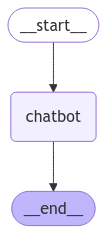

In [63]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage


# OPENAI_API_KEY environment variable must be set
llm = ChatOpenAI(model="gpt-4o-mini")

# System message
chatbot_system_message = SystemMessage(content=("""
You are a helpful and knowledgeable chatbot assistant. 
Your goal is to provide clear and accurate answers to user questions based on the information they provide. 
Stay focused, concise, and ensure your responses are relevant to the context of the conversation. 
If you don’t have enough information, ask for clarification.”
"""))


# Nodes
def chatbot(state: MessagesState) -> MessagesState:
    response = llm.invoke([chatbot_system_message] + state["messages"]);
    return MessagesState(messages = [response])


# Graph
workflow = StateGraph(MessagesState)
workflow.add_node(chatbot)

workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)


memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Streaming modes:

- updates (exposes only new data)
- values (always shows the whole state)
- messages
- debug
- custom

### Stream_mode=updates

In [64]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

user_input = HumanMessage(content="Hi, I’m working on a Python project, and I’m stuck with handling API responses.")
for event in graph.stream({"messages": [user_input]}, config, stream_mode="updates"):
    print(event)

{'chatbot': {'messages': [AIMessage(content='I can help with that! What specific issues are you encountering with handling API responses in your Python project? Are you having trouble parsing the response, dealing with errors, or something else?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 92, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-78db9f95-83f8-41f1-b779-d667497c1b52-0', usage_metadata={'input_tokens': 92, 'output_tokens': 38, 'total_tokens': 130, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


In [65]:
user_input = HumanMessage(content="Sorry what was my previous question?")
for event in graph.stream({"messages": [user_input]}, config, stream_mode="updates"):
    for m in event['chatbot']['messages']:
        m.pretty_print()

================================== Ai Message ==================================

You mentioned that you are working on a Python project and that you’re stuck with handling API responses. How can I assist you further with that?


### Stream_mode=values

In [66]:
config = {"configurable": {"thread_id": "2"}}

user_input = HumanMessage(content="Hi, I’m working on a Python project, and I’m stuck with handling API responses.")
for event in graph.stream({"messages": [user_input]}, config, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='Hi, I’m working on a Python project, and I’m stuck with handling API responses.', additional_kwargs={}, response_metadata={}, id='0b8d3a53-21b9-4b06-928f-a594512a5bdf')]}
{'messages': [HumanMessage(content='Hi, I’m working on a Python project, and I’m stuck with handling API responses.', additional_kwargs={}, response_metadata={}, id='0b8d3a53-21b9-4b06-928f-a594512a5bdf'), AIMessage(content='I can help with that! Can you provide more details about the API you’re working with, the issues you’re facing, and what you’ve tried so far?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 92, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 

In [67]:
config = {"configurable": {"thread_id": "2"}}

user_input = HumanMessage(content="Hi, I’m working on a Python project, and I’m stuck with handling API responses.")
for event in graph.stream({"messages": [user_input]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("\n")
    print("#"*100)
    print("\n")

================================ Human Message =================================

Hi, I’m working on a Python project, and I’m stuck with handling API responses.
================================== Ai Message ==================================

I can help with that! Can you provide more details about the API you’re working with, the issues you’re facing, and what you’ve tried so far?
================================ Human Message =================================

Hi, I’m working on a Python project, and I’m stuck with handling API responses.


####################################################################################################


================================ Human Message =================================

Hi, I’m working on a Python project, and I’m stuck with handling API responses.
================================== Ai Message ==================================

I can help with that! Can you provide more details about the API you’re working with, the issues you’re

### Streaming deeper (updates inside Node) - a.k.a. "streaming LLM tokens from a specific node"

In [68]:
config = {"configurable": {"thread_id": "4"}}

user_input = HumanMessage(content="Hi, I’m working on a Python project, and I’m stuck with handling API responses.")
for event in graph.stream({"messages": [user_input]}, config, stream_mode="messages"):
    print(event)

# so we have a message with content and metadata

(AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-6b71448d-8da0-4513-9301-bcbf55255997'), {'thread_id': '4', 'langgraph_step': 1, 'langgraph_node': 'chatbot', 'langgraph_triggers': ['start:chatbot'], 'langgraph_path': ('__pregel_pull', 'chatbot'), 'langgraph_checkpoint_ns': 'chatbot:ecabe036-7295-522c-495c-54790fc26824', 'checkpoint_ns': 'chatbot:ecabe036-7295-522c-495c-54790fc26824', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o-mini', 'ls_model_type': 'chat', 'ls_temperature': None})
(AIMessageChunk(content='I', additional_kwargs={}, response_metadata={}, id='run-6b71448d-8da0-4513-9301-bcbf55255997'), {'thread_id': '4', 'langgraph_step': 1, 'langgraph_node': 'chatbot', 'langgraph_triggers': ['start:chatbot'], 'langgraph_path': ('__pregel_pull', 'chatbot'), 'langgraph_checkpoint_ns': 'chatbot:ecabe036-7295-522c-495c-54790fc26824', 'checkpoint_ns': 'chatbot:ecabe036-7295-522c-495c-54790fc26824', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o-mini',

In [69]:
config = {"configurable": {"thread_id": "4"}}

user_input = HumanMessage(content="Ahh, yeah right! So I’m mostly struggling with parsing JSON responses. Sometimes the structure isn’t what I expect, and it breaks my code.")
for msg, metadata in graph.stream({"messages": [user_input]}, config, stream_mode="messages"):
    if (metadata['langgraph_node'] == 'chatbot'):
        print(msg.content, end="")

# same style of outputing data as in chat app (a token by token)

Parsing JSON responses can indeed be tricky if the structure varies. Here are some general tips to handle this:

1. **Use `try-except` Blocks**: This can help catch any exceptions that occur when accessing nested keys that might not exist.

   ```python
   import requests

   response = requests.get('your_api_endpoint')
   data = response.json()

   try:
       value = data['expected_key']
   except KeyError:
       print("Key not found, handle it appropriately.")
   ```

2. **Check for Key Existence**: Before accessing a nested key, check if it exists using `dict.get()` or the `in` keyword.

   ```python
   if 'expected_key' in data:
       value = data['expected_key']
   else:
       print("Key not found")
   ```

3. **Use Default Values**: The `get()` method allows you to set a default value if the key does not exist.

   ```python
   value = data.get('expected_key', 'default_value')
   ```

4. **Inspect the Structure**: Print the entire response or part of it to understand its stru

## Streaming with LangGraph API

In [ ]:
from langgraph_sdk import get_client

URL = "http://localhost:61693"
client = get_client(url=URL)

assistants = await client.assistants.search()
assistants

In [ ]:
thread = await client.threads.create()

input_message = HumanMessage(content="Hi, I’m working on a Python project, and I’m stuck with handling API responses.")

async for part in client.runs.stream(
        thread["thread_id"], 
        assistant_id="8a4ac7a4-50eb-5206-98cc-4a72345cb1f7", 
        input={"messages": [input_message]}, 
        stream_mode="messages"):
    print(part)

# check event types

In [ ]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()
input_message = HumanMessage(content="Should I invest in Tesla stocks?")

async for event in client.runs.stream(
            thread["thread_id"], 
            assistant_id="b7480eb0-6390-53a5-9bc4-29bf27cbd1c4", 
            input={"messages": [input_message]}, 
            stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])

# display content only with convert_to_messages util